#### 0. <a href=#Prepare-conda-environment>Prepare conda environment</a> 
#### 1. <a href=#Pull-functions-from-the-code-repository>Pull utility codes from a repository</a>
#### 2. <a href=#Load-Python-Libraries>Load libraries</a>
#### 3. <a href=#Utility-functions> Make some utility functions</a> 
#### 4. <a href=#Load-the-data>Load train and test files</a> 
#### 5. <a href=#Get-predictions-from-individual-nets> Make predictions from individual nets </a> 
#### 6. <a href=#Blend-the-solutions-with-weights> Blend predictions from individual nets </a> 
#### 7. <a href=#Generate-submission-file> Generate submission file</a>


# Prepare conda environment


# Pull functions from the code repository

This should automatically pull the codes from a Google Drive link below + the neural network models with weights. Works on Linux. If on Windows - download the codes manually and place them in the folder with the notebook.

Since training of all three models took a while, we recommend just using the weights provided for the predictions.

Our submission is a weighted blend of UNET and LSTM networks with sub-band decomposition.

# Load Python Libraries

In [1]:
# data processing
import pandas as pd
import numpy as np
from scipy.signal import medfilt
from sklearn.preprocessing import MinMaxScaler
#model estimation
from sklearn.metrics import accuracy_score
#custom functions from the downloaded code base
from config import *
from DataGenerator import *
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)


Using TensorFlow backend.
/home/anton/miniconda3/envs/py36tfnew/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/anton/miniconda3/envs/py36tfnew/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/anton/miniconda3/envs/py36tfnew/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/anton

/home/anton/miniconda3/envs/py36tfnew/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/anton/miniconda3/envs/py36tfnew/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/anton/miniconda3/envs/py36tfnew/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/anton/mini

# Utility functions

In [13]:
def prepare_test(pred_test, df_test):
    wells = df_test['well_id'].sort_values().unique().tolist()
    list_df_wells = [df_test.loc[df_test['well_id'].isin([w]), :].copy() for w in wells]
    for df in list_df_wells:
        df.index = np.arange(df.shape[0])
    for i, df_well in enumerate(list_df_wells):
        df_well['label'] = np.argmax(pred_test[i, :], axis=1)
    result = pd.concat(list_df_wells, axis=0)
    return result

def validation(Pipeline_object, weights_location_list,folds = [1,2,3]):
    print('Validation started')
    # kfold cross-validation
    kf = KFold(5, shuffle=True, random_state=42)

    predictions = np.zeros((GetData.X_test.shape[0], GetData.X_test.shape[1], 5))
    score = 0
    pred_val_dict = {}
    predictions_test = np.zeros((GetData.X_test.shape[0], 1104, 5))

    for fold, (train_ind, val_ind) in enumerate(kf.split(GetData.X_train)):
        if not(fold in folds):
            continue
        weights_loc = weights_location_list[fold]
        print(f'Doing fold {fold}')

        X_train, y_train, X_val, y_val = GetData.get_train_val(train_ind, val_ind)
        # self.model = self.model_func(input_size=INPUT_SIZE, hyperparams=HYPERPARAM)
        model = load_model(weights_loc)

        pred_val = model.predict(X_val)
        pred_val_dict[fold] = pred_val.copy()
        pred_val_dict[f'{fold}_y_val'] = y_val.copy()
        pred_val_dict[f'{fold}_X_val'] = X_val.copy()

        predictions_test += model.predict(GetData.X_test) / 5

    predictions_test = predictions_test[:, :1100:, :]

    return pred_val_dict, predictions_test



# Load the data

To run on a private test set, set `TEST_NAME` to a location of the private test csv, and place the file into the folder specified by `DATA_PATH`

In [3]:
DATA_PATH = './data/raw/'
TEST_NAME = f'{DATA_PATH}test_cax.csv'
test = pd.read_csv(TEST_NAME)
test.head()

,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.950000
1,CAX_1,1,5000,120.896397
2,CAX_2,2,5000,115.342793
3,CAX_3,3,5000,118.859190
4,CAX_4,4,5000,127.735587


In [4]:
GetData=DataGenerator()

  0%|          | 11/4000 [00:00<00:37, 106.92it/s]

Performing a rescale on note..


  1%|          | 12/2000 [00:00<00:17, 112.90it/s]

Performing a rescale on note..


100%|██████████| 2000/2000 [00:18<00:00, 109.56it/s]


### Get predictions from individual nets

In [14]:
# Run UNET predictions
model_list = [f'./data/weights/UNET_model_{i}_.h5' for i in range(3)]

pred_val_dict, pred_test = validation(GetData,model_list,folds=[0,1,2])


Validation started
Doing fold 0
Doing fold 1
Doing fold 2


In [66]:
fold = 0
ids = []
for well_id in range(pred_val_dict[fold].shape[0]):
    labels_pred = np.argmax(pred_val_dict[fold][well_id,:],axis=1)
    labels_true = np.argmax(pred_val_dict[f'{fold}_y_val'][well_id,:],axis=1)
    score = accuracy_score(labels_true,labels_pred)
    if score < 0.91:
        ids.append(well_id)
        print(f'{well_id} -- {score}')
    

27 -- 0.9085144927536232
88 -- 0.8967391304347826
96 -- 0.8967391304347826
111 -- 0.9057971014492754
220 -- 0.9003623188405797
254 -- 0.9094202898550725
259 -- 0.8958333333333334
279 -- 0.8795289855072463
361 -- 0.8976449275362319
394 -- 0.8976449275362319
458 -- 0.9085144927536232
462 -- 0.9021739130434783
531 -- 0.9085144927536232
581 -- 0.9003623188405797
587 -- 0.907608695652174
609 -- 0.8967391304347826
618 -- 0.8686594202898551
729 -- 0.904891304347826
777 -- 0.9094202898550725
797 -- 0.9094202898550725


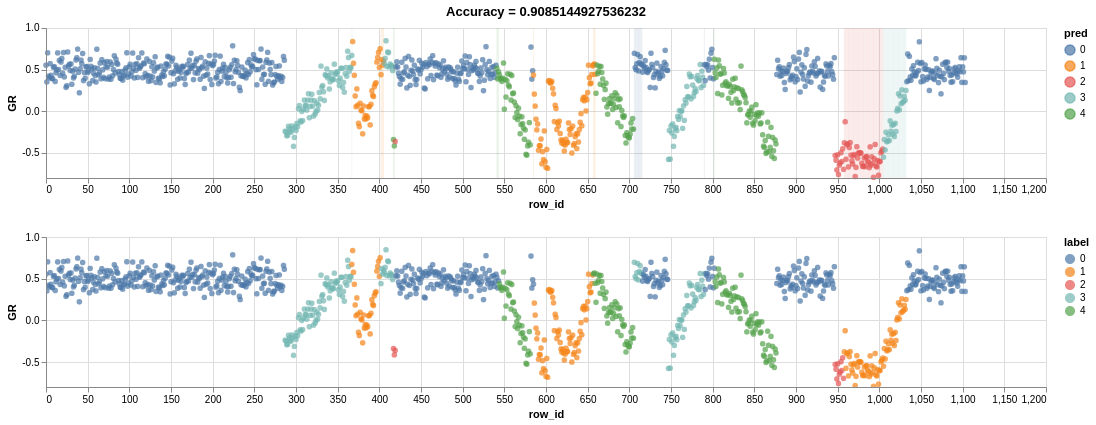

In [86]:
import altair as alt
from sklearn.metrics import accuracy_score
alt.renderers.enable('notebook')
alt.data_transformers.disable_max_rows()
well_id = np.random.choice(ids,size=1)[0]
labels_pred = np.argmax(pred_val_dict[fold][well_id,:],axis=1)
labels_true = np.argmax(pred_val_dict[f'{fold}_y_val'][well_id,:],axis=1)
score = accuracy_score(labels_true,labels_pred)
gr = pred_val_dict[f'{fold}_X_val'][well_id,:,0]
df_sub = pd.DataFrame({'GR':gr,'pred':labels_pred,'label':labels_true,'row_id':np.arange(gr.shape[0])})
df_rules = df_sub[df_sub['label'] != df_sub['pred']]
rules_ch = alt.Chart(df_rules,width=1000,height=150).encode(x='row_id',color='pred:N').mark_rule(opacity=0.1)
pred_ch = alt.Chart(df_sub,width=1000,height=150,title = f'Accuracy = {score}').encode(x='row_id',y='GR',color='pred:N').mark_point(filled=True)
truth_ch = alt.Chart(df_sub,width=1000,height=150).encode(x='row_id',y='GR',color='label:N').mark_point(filled=True)
( (pred_ch+rules_ch) & truth_ch.interactive()).resolve_scale(color='independent')

In [59]:
well_id

27

### Blend the solutions with weights

## Generate submission file


In [81]:
predictions_total = pred_test
submit = prepare_test(predictions_total, test)
submit[['unique_id','label']].to_csv('data/result/submit_CAX.csv', index=False)